In [1]:
#!pip install pandas
#!pip install tensorflow[and-cuda]
#!pip install keras-tuner

In [2]:
#!pip install pandas
#!pip install networkx
#!pip install matplotlib
#!pip install scikit-learn

In [3]:
import pandas as pd
from keras.src.layers import Bidirectional

from component_module import drop_static_columns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
# for keras tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

import matplotlib.pyplot as plt
import numpy as np

2024-09-18 22:43:17.231710: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 22:43:17.253905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 22:43:17.281934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 22:43:17.290134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 22:43:17.309762: I tensorflow/core/platform/cpu_feature_guar

In [4]:
# Check if TensorFlow is built with CUDA support
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available")
    print(f"Device: {tf.config.list_physical_devices('GPU')[0]}")
else:
    print("CUDA is not available")

CUDA is available
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1726695800.623833   57102 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726695800.649259   57102 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726695800.649429   57102 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355



df = pd.read_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT DataSWaT 2015-12-23.csv")

#df.head()
df,  dropped_cols= drop_static_columns(df)
# convert time to seconds since midnight
# Convert 'Timestamp' column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['time_in_seconds'] = (df['Timestamp'].dt.hour * 3600 + df['Timestamp'].dt.minute * 60 + df['Timestamp'].dt.second)              
df.set_index('time_in_seconds', inplace=True)
df.drop(columns=['Timestamp', 'time'], inplace=True)

# normalised data
scaler = StandardScaler()
df_normalised = scaler.fit_transform(df)
# convert back to df
df_normalised = pd.DataFrame(df_normalised, columns=df.columns)
df_normalised.to_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT_2015_12_23_for_tf.csv",index=False)



In [5]:
df = pd.read_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT_2015_12_23_for_tf.csv")

In [6]:
df.head()

,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,MV201,P203,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,P602
0,-1.608031,1.824135,-1.55021,0.585352,2.475287,-0.112313,0.578473,0.085272,0.579321,-1.699887,...,1.386669,0.072135,0.363321,-0.274278,-0.576233,-0.282796,-1.05009,-0.233109,-0.096308,-0.088802
1,-1.608031,1.821131,-1.55021,0.585352,2.475287,-0.112313,0.581718,0.306260,0.579321,0.588275,...,1.386669,0.072135,-0.623212,-0.274278,0.735024,-0.328344,-1.05009,-0.233109,-0.096308,-0.088802
2,-1.608031,1.821131,-1.55021,0.585352,2.475287,-0.112313,0.589288,0.430235,0.579321,0.588275,...,1.386669,0.072135,-0.723537,-0.274278,0.735024,-0.442179,-1.05009,-0.246041,-0.096308,-0.088802
3,-1.608031,1.820797,-1.55021,0.585352,2.341305,-0.124024,0.597939,0.512685,0.579321,0.588275,...,1.386669,0.072135,-0.297175,0.905646,0.735024,-0.442179,-1.05009,-0.362587,-0.096308,-0.088802
4,-1.608031,1.818460,-1.55021,0.585352,2.341305,-0.124024,0.610196,0.565044,0.579321,0.588275,...,1.386669,0.072135,0.681068,0.905646,0.735024,-0.294165,-1.05009,-0.362587,-0.096308,-0.088802


In [7]:
component_map = list(df.columns)
len(component_map)

37

In [8]:
# check data is in time order
#df.sort_values(by='time_in_seconds', inplace=True)

In [9]:
df_test = df
df_test.shape

(86400, 37)

In [10]:
#df_test.set_index('time_in_seconds', inplace=True)
data_array = df_test.to_numpy()




In [11]:
# shape of array
data_array.shape

(86400, 37)

In [12]:
# dataset in single slices of array so 1 second rows
#dataset.element_spec

In [13]:
# Window size in seconds
window_size = 20
# Define batch of windows to process in parallel before updating weights 
batch_size = 32


def windowed_dataset(data_array, window_size, batch_size):
    '''
    get full dataset as np array
    :param series: 
    :param window_size: 
    :param batch_size: 
    :return: 
    '''
    
    # Create a TensorFlow dataset from the NumPy array
    dataset = tf.data.Dataset.from_tensor_slices(data_array)

    # Window the dataset into n second long slices with a 1 sec shift between each
    dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
    
    # Flatten the windowed dataset for input layer
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Split window into features and labels (last row)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    
    # batch 
    dataset = dataset.batch(batch_size)
    
    # set indefinite repeat to allow looping back through
    #dataset = dataset.repeat()
    
    return dataset
    
    

In [14]:
split_time = int(data_array.shape[0] * 0.8)
train_dataset = data_array[:split_time]
val_dataset = data_array[split_time:]
train_dataset.shape
val_dataset.shape

(17280, 37)

In [15]:
train_dataset = windowed_dataset(train_dataset, window_size, batch_size)
val_dataset = windowed_dataset(val_dataset, window_size, batch_size)

I0000 00:00:1726695801.901169   57102 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726695801.901491   57102 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726695801.901670   57102 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726695801.965557   57102 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [16]:
# Check the first window
for features, label in train_dataset.take(1):
    print("Features shape: ", features.shape)  # Should be (19, 37)
    print("Label shape: ", label.shape)        # Should be (37,)

Features shape:  (32, 19, 37)
Label shape:  (32, 1, 37)


2024-09-18 22:43:22.268639: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# Count the number of windows
num_windows = train_dataset.reduce(0, lambda x, _: x + 1).numpy() * batch_size


print(f"Number of windows: {num_windows}")

Number of windows: 69120


# split data
train_size = int(0.8 * num_windows)
train_dataset = windowed_dataset.take(train_size)
val_dataset = windowed_dataset.skip(train_size)

# batch data
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [18]:
for feature, lable in train_dataset.take((1)):
    print(feature.numpy().shape)

(32, 19, 37)


2024-09-18 22:43:26.773619: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
(window_size - 1, data_array.shape[1])

(19, 37)

# Hyperparameter Optimisation



In [20]:
def build_model():
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    
   
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add an LSTM layer with 50 units (neurons) and 
    model.add(LSTM(50))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=0.001)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    # Print model summary
    model.summary()
    
    # epochs is number of times to iterate through whole dataset
    epochs = 10
    
    batch_size = 32
    # floor steps per epoch calculated to avoid error
    steps_per_epoch = num_windows // batch_size 
    
    return model, epochs, steps_per_epoch



In [21]:
def build_bi_model():
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    
    
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add bidirectional LSTM layer with 50 units (neurons) 
    model.add(Bidirectional(LSTM(50)))
       
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=0.0001)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    # Print model summary
    model.summary()
    
    # epochs is number of times to iterate through whole dataset
    epochs = 10
    
    batch_size = 32
    
    # floor steps per epoch calculated to avoid error
    steps_per_epoch = num_windows // batch_size 
    
    return model, epochs, steps_per_epoch



In [23]:
#tuner = RandomSearch(build_model,
 #                        )

In [24]:
model, epochs, steps_per_epoch = build_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        17,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 37)             │         1,887 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,487 (76.12 KB)

 Trainable params: 19,487 (76.12 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
bi_model, epochs, bi_steps_per_epoch = build_bi_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 100)            │        35,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         3,737 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,937 (152.10 KB)

 Trainable params: 38,937 (152.10 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
history = model.fit(
    train_dataset,
    epochs=epochs,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)


Epoch 1/10


2024-09-18 22:44:09.300630: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   2158/Unknown 11s 4ms/step - loss: 0.3488 - mae: 0.3175

2024-09-18 22:44:18.814851: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.3488 - mae: 0.3174 - val_loss: 0.2491 - val_mae: 0.2726
Epoch 2/10
  34/2160 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3888 - mae: 0.4300

2024-09-18 22:44:20.119985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14498747464721336333
2024-09-18 22:44:20.120024: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3882594385065337613
2024-09-18 22:44:20.120036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18407517354099173388


2155/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2278 - mae: 0.2408

2024-09-18 22:44:29.222141: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.2278 - mae: 0.2407 - val_loss: 0.2545 - val_mae: 0.2776
Epoch 3/10
  37/2160 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.2584 - mae: 0.3348

2024-09-18 22:44:30.371363: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14498747464721336333
2024-09-18 22:44:30.371413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3882594385065337613
2024-09-18 22:44:30.371429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18407517354099173388


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1978 - mae: 0.2089 - val_loss: 0.2390 - val_mae: 0.2538
Epoch 4/10
  35/2160 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1694 - mae: 0.2584 

2024-09-18 22:44:40.378439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14498747464721336333
2024-09-18 22:44:40.378484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3882594385065337613
2024-09-18 22:44:40.378498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18407517354099173388


2149/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1816 - mae: 0.1882

2024-09-18 22:44:49.654472: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-09-18 22:44:49.654554: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11362605100681139019
2024-09-18 22:44:49.654573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4224931511526974353
2024-09-18 22:44:49.654587: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7758986552533212978


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1817 - mae: 0.1881 - val_loss: 0.2245 - val_mae: 0.2434
Epoch 5/10
  36/2160 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1475 - mae: 0.2480

2024-09-18 22:44:50.796069: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14498747464721336333
2024-09-18 22:44:50.796112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3882594385065337613
2024-09-18 22:44:50.796139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18407517354099173388


2158/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1747 - mae: 0.1793

2024-09-18 22:44:59.604521: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6857422759768694574
2024-09-18 22:44:59.604575: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17910506684341846105
2024-09-18 22:44:59.604589: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11362605100681139019
2024-09-18 22:44:59.604598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4224931511526974353
2024-09-18 22:44:59.604609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7758986552533212978


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1747 - mae: 0.1792 - val_loss: 0.2153 - val_mae: 0.2258
Epoch 6/10
  35/2160 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1195 - mae: 0.2122

2024-09-18 22:45:00.769021: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3882594385065337613
2024-09-18 22:45:00.769094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18407517354099173388


2154/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1697 - mae: 0.1715

2024-09-18 22:45:09.550997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11362605100681139019
2024-09-18 22:45:09.551037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4224931511526974353
2024-09-18 22:45:09.551052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7758986552533212978


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1697 - mae: 0.1715 - val_loss: 0.2129 - val_mae: 0.2231
Epoch 7/10
2148/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1653 - mae: 0.1643

2024-09-18 22:45:20.113124: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11362605100681139019
2024-09-18 22:45:20.113165: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4224931511526974353
2024-09-18 22:45:20.113178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7758986552533212978


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1653 - mae: 0.1642 - val_loss: 0.2159 - val_mae: 0.2278
Epoch 8/10
  33/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0909 - mae: 0.1813

2024-09-18 22:45:21.287582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14498747464721336333
2024-09-18 22:45:21.287630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3882594385065337613
2024-09-18 22:45:21.287657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18407517354099173388


2150/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1619 - mae: 0.1589

2024-09-18 22:45:30.012959: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6857422759768694574
2024-09-18 22:45:30.013009: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/mean_squared_error/mod/_14]]
2024-09-18 22:45:30.013045: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17910506684341846105
2024-09-18 22:45:30.013056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11362605100681139019
2024-09-18 22:45:30.013062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4224931511526974353
2024-09-18 22:45:30.013155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 77589

2160/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1620 - mae: 0.1588 - val_loss: 0.2159 - val_mae: 0.2237
Epoch 9/10
  33/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0833 - mae: 0.1735

2024-09-18 22:45:31.195167: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14498747464721336333
2024-09-18 22:45:31.195210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3882594385065337613
2024-09-18 22:45:31.195233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18407517354099173388


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1603 - mae: 0.1556 - val_loss: 0.2166 - val_mae: 0.2222
Epoch 10/10
  37/2160 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0757 - mae: 0.1586 

2024-09-18 22:45:41.271391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14498747464721336333
2024-09-18 22:45:41.271429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3882594385065337613
2024-09-18 22:45:41.271442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18407517354099173388


2150/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1580 - mae: 0.1526

2024-09-18 22:45:50.126246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11362605100681139019
2024-09-18 22:45:50.126289: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4224931511526974353
2024-09-18 22:45:50.126304: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7758986552533212978


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1581 - mae: 0.1526 - val_loss: 0.2153 - val_mae: 0.2228


2024-09-18 22:45:51.281349: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3882594385065337613
2024-09-18 22:45:51.281384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18407517354099173388


In [27]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
bi_history = bi_model.fit(
    train_dataset,
    epochs=epochs,
    #steps_per_epoch=bi_steps_per_epoch,
    validation_data=val_dataset
)



Epoch 1/10
   2152/Unknown 13s 6ms/step - loss: 0.5446 - mae: 0.4697

2024-09-18 22:47:18.454339: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:47:18.454385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:47:18.454398: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.5442 - mae: 0.4694 - val_loss: 0.2896 - val_mae: 0.3069
Epoch 2/10
  27/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.3418 - mae: 0.4109

2024-09-18 22:47:19.966980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:47:19.967036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:47:19.967053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2153/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2913 - mae: 0.2860

2024-09-18 22:47:32.610430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:47:32.610479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:47:32.610492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.2912 - mae: 0.2859 - val_loss: 0.2401 - val_mae: 0.2684
Epoch 3/10
  28/2160 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.2140 - mae: 0.3236

2024-09-18 22:47:33.955281: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:47:33.955323: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:47:33.955347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2153/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2252 - mae: 0.2320

2024-09-18 22:47:46.209628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:47:46.209673: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:47:46.209686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.2252 - mae: 0.2319 - val_loss: 0.2102 - val_mae: 0.2454
Epoch 4/10
  20/2160 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.1660 - mae: 0.2810

2024-09-18 22:47:47.579264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:47:47.579317: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:47:47.579327: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2158/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1962 - mae: 0.2035

2024-09-18 22:48:01.412614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:48:01.412687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:48:01.412698: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.1962 - mae: 0.2035 - val_loss: 0.1916 - val_mae: 0.2289
Epoch 5/10
  23/2160 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.1288 - mae: 0.2444

2024-09-18 22:48:03.057834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:48:03.057885: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:48:03.057899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2156/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1807 - mae: 0.1864

2024-09-18 22:48:16.401675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:48:16.401726: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:48:16.401743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348
2024-09-18 22:48:16.401751: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10674525157249131382
2024-09-18 22:48:16.401759: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17791042572033723944


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.1807 - mae: 0.1863 - val_loss: 0.1807 - val_mae: 0.2197
Epoch 6/10
  29/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.1024 - mae: 0.2143

2024-09-18 22:48:17.938559: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:48:17.938607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:48:17.938634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2154/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1716 - mae: 0.1744

2024-09-18 22:48:30.238148: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-09-18 22:48:30.238194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:48:30.238209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:48:30.238223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348
2024-09-18 22:48:30.238232: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10674525157249131382
2024-09-18 22:48:30.238241: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17791042572033723944


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.1716 - mae: 0.1744 - val_loss: 0.1737 - val_mae: 0.2130
Epoch 7/10
  25/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0910 - mae: 0.1989

2024-09-18 22:48:31.656895: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:48:31.656934: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:48:31.656941: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2159/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1661 - mae: 0.1660

2024-09-18 22:48:44.090963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:48:44.091013: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:48:44.091030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.1661 - mae: 0.1660 - val_loss: 0.1688 - val_mae: 0.2075
Epoch 8/10
  23/2160 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0834 - mae: 0.1882

2024-09-18 22:48:45.484705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:48:45.484756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:48:45.484774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1624 - mae: 0.1598

2024-09-18 22:48:57.449536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:48:57.449580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:48:57.449605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348
2024-09-18 22:48:57.449613: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10674525157249131382
2024-09-18 22:48:57.449619: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17791042572033723944


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.1624 - mae: 0.1598 - val_loss: 0.1649 - val_mae: 0.2029
Epoch 9/10
  25/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0772 - mae: 0.1776

2024-09-18 22:48:58.800370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:48:58.800423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2154/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1595 - mae: 0.1548

2024-09-18 22:49:11.532043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.1596 - mae: 0.1548 - val_loss: 0.1619 - val_mae: 0.1991
Epoch 10/10
  27/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0724 - mae: 0.1679

2024-09-18 22:49:13.025087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:49:13.025125: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:49:13.025131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.1574 - mae: 0.1506 - val_loss: 0.1598 - val_mae: 0.1961


2024-09-18 22:49:26.982445: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839


In [46]:
#history_dict['val_mae']

[0.30992981791496277,
 0.3008570373058319,
 0.28729987144470215,
 0.2620809078216553,
 0.2625470459461212,
 0.269218385219574,
 0.2402947098016739,
 0.24070829153060913,
 0.26532796025276184,
 0.2421676367521286,
 0.24359402060508728,
 0.2437315434217453,
 0.24171429872512817,
 0.261157363653183,
 0.252514123916626]

In [44]:
#history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

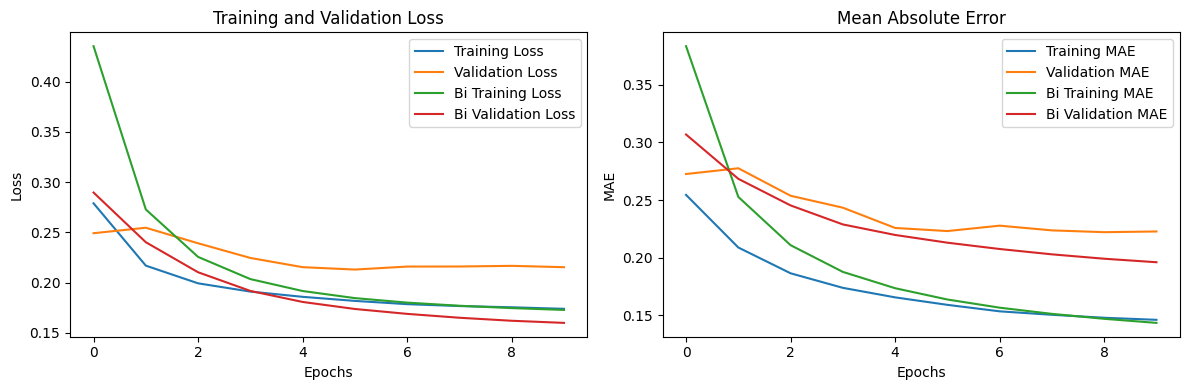

In [28]:


# Assuming `history` is the output from model.fit()

history_dict = history.history
bi_history_dict = bi_history.history

# Plot training & validation loss
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
if 'val_loss' in history_dict:
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    
plt.plot(bi_history_dict['loss'], label='Bi Training Loss')
if 'val_loss' in bi_history_dict:
    plt.plot(bi_history_dict['val_loss'], label='Bi Validation Loss')
    

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy (if available)
plt.subplot(1, 2, 2)

if 'mae' in history_dict:
    plt.plot(history_dict['mae'], label='Training MAE')
if 'val_mae' in history_dict:
    plt.plot(history_dict['val_mae'], label='Validation MAE')
 
if 'mae' in bi_history_dict:
    plt.plot(bi_history_dict['mae'], label='Bi Training MAE')
if 'val_mae' in bi_history_dict:
    plt.plot(bi_history_dict['val_mae'], label='Bi Validation MAE')  

plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [16]:
model.save('swat_lstm_100s.keras')

# Open Saved Model

In [20]:
# Load the model from the SavedModel directory
# 20 secs
#swat_lstm = tf.keras.models.load_model('swat_lstm_1_0.keras')
swat_lstm = tf.keras.models.load_model('swat_lstm_100s.keras')
model_window = 100

In [21]:
# Reshape the input from data_array to add the batch dimension
reshaped_input = data_array[:model_window-1, :].reshape(1, model_window-1, data_array.shape[1])  # (1, 19, 37)

# Make predictions
predictions = swat_lstm.predict(reshaped_input)

# Print predictions
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[-1.6873796   1.0725484  -1.6856784   0.5893998   1.2647659  -0.6372988
   0.81754637  0.5705057   0.5782185   0.5621133  -1.0134225   0.46552265
   0.3625184  -1.7182541  -0.08421671  0.45475912 -0.03200638 -0.09545343
  -0.00451893  0.34572366 -0.7700037   0.22403386  0.01046308 -1.1046661
  -0.38610268  0.06470605  0.83374614  1.4891282   0.08482892  0.150914
  -0.49433717  0.16404936 -0.7478318  -1.3892689  -0.76368266 -0.03951834
  -0.00188439]]


In [22]:
actual = data_array[model_window-1:model_window, :]

In [27]:
reshaped_input.shape

(1, 99, 37)

In [25]:
actual

array([[-1.60803075,  1.39821286, -1.55020996,  0.58535159,  2.14028964,
        -0.51839683,  0.71329708,  0.61367085,  0.57932135,  0.58827456,
        -0.92233481,  0.51362799,  0.46787354, -1.57205191, -0.04912496,
         0.48112757, -0.11892534, -0.12449482, -0.01128411,  0.46178413,
        -0.79145985,  0.90939238,  0.15634357, -1.11978876, -0.34043019,
         0.93175224,  1.00190234,  1.50947237, -0.12515386, -1.29212782,
        -0.27427769,  0.68043468, -0.55601419, -1.29954125, -0.49206393,
        -0.09630808, -0.08880187]])

In [23]:
difference = actual - predictions

# Print results
print("Predictions:\n", predictions)
print("Actual Values:\n", actual)
print("Difference:\n", difference)

Predictions:
 [[-1.6873796   1.0725484  -1.6856784   0.5893998   1.2647659  -0.6372988
   0.81754637  0.5705057   0.5782185   0.5621133  -1.0134225   0.46552265
   0.3625184  -1.7182541  -0.08421671  0.45475912 -0.03200638 -0.09545343
  -0.00451893  0.34572366 -0.7700037   0.22403386  0.01046308 -1.1046661
  -0.38610268  0.06470605  0.83374614  1.4891282   0.08482892  0.150914
  -0.49433717  0.16404936 -0.7478318  -1.3892689  -0.76368266 -0.03951834
  -0.00188439]]
Actual Values:
 [[-1.60803075  1.39821286 -1.55020996  0.58535159  2.14028964 -0.51839683
   0.71329708  0.61367085  0.57932135  0.58827456 -0.92233481  0.51362799
   0.46787354 -1.57205191 -0.04912496  0.48112757 -0.11892534 -0.12449482
  -0.01128411  0.46178413 -0.79145985  0.90939238  0.15634357 -1.11978876
  -0.34043019  0.93175224  1.00190234  1.50947237 -0.12515386 -1.29212782
  -0.27427769  0.68043468 -0.55601419 -1.29954125 -0.49206393 -0.09630808
  -0.08880187]]
Difference:
 [[ 7.93488498e-02  3.25664471e-01  1.3546

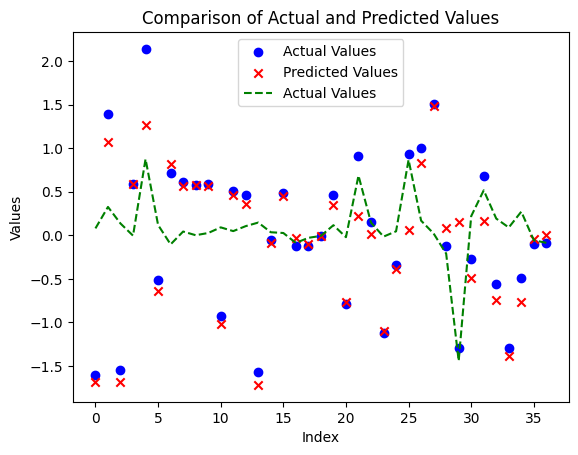

In [24]:
type(actual[0])
actual_list = list(actual[0])
predictions_list = list(predictions[0])
x_values = list(range(len(actual_list)))
difference = actual - predictions
difference_list = list(difference[0])
# Plot the actual values
plt.scatter(x_values, actual_list, color='blue', label='Actual Values', marker='o')

# Plot the predicted values
plt.scatter(x_values, predictions_list, color='red', label='Predicted Values', marker='x')

plt.plot(x_values, difference_list, color='green', label='Actual Values', linestyle='--')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Actual and Predicted Values')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [36]:
type(difference_list)

NameError: name 'difference_list' is not defined

# Train Agent

In [50]:
class Agent:
    def __init__(self):
        pass

    def choose_action(self, state):
        # For simplicity, let's assume the agent alters a random element
        # in the state by adding a small random value to it
        action = np.random.choice(range(37))  # Randomly choose which element to modify
        modification = np.random.uniform(-0.1, 0.1)  # Random change
        return action, modification

    def apply_action(self, state, action, modification):
        # Modify the chosen element in the state
        new_state = np.copy(state)
        new_state[action] += modification
        return new_state


In [ ]:
# Initialize agent
agent = Agent()

# Create a window of previous states (e.g., randomly initialized for simplicity)
#current_window = np.random.rand(1, window_size, 37)  # Shape: (1, 20, 37)

# real window from dataset
# Reshape the input from data_array to add the batch dimension
current_window = data_array[:19, :].reshape(1, 19, data_array.shape[1])  # (1, 19, 37)


# Loop through multiple episodes
for episode in range(100):  # Number of episodes
    for t in range(100):  # Time steps in each episode
        # Step 1: Predict the next state using the LSTM environment model
        predicted_next_state = swat_lstm.predict(current_window)

        # Step 2: Agent chooses an action to modify the state
        action, modification = agent.choose_action(predicted_next_state[0])

        # Step 3: Apply the action (modification) to the predicted state
        modified_state = agent.apply_action(predicted_next_state[0], action, modification)

        # Step 4: Update the input window by adding the modified state to it
        # Shift window, add modified state as the last timestep
        current_window = np.roll(current_window, shift=-1, axis=1)  # Shift the window
        current_window[0, -1, :] = modified_state  # Add modified state to the last position

        # Reward: Define a reward based on how well the chosen element is maximized
        target_name = 'LIT101'
        # get component position in 37 element list
        target_pos = component_map.index(target_name)
        reward = modified_state[target_pos]  # Reward is based on this element's value

        # Here, you would typically train your agent using an RL algorithm
        # This could involve storing transitions (state, action, reward, next_state)
        # and updating the policy/agent using an algorithm like Q-learning, DDPG, or PPO

    # End of episode: Evaluate performance, adjust hyperparameters, etc.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [ ]:
print('test')